# Some Web Scrapping with Pandas
In this notebook we do some Web Scrapping with the pandas __pd.read_html(url)__ method, and then we apply some preprocessing and visualization, and finally we create a __PCA__.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import plotly.express as px


tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_World_Heritage_in_Danger")
len(tables)

5

# Get and Preprocess Data

We obtain the data with the Pandas librarie from de url: https://en.wikipedia.org/wiki/List_of_World_Heritage_in_Danger

In [2]:
frames = [tables[1], tables[3]]
data = pd.concat(frames).reset_index(drop= True)
data.head(5)

,Name,Image,Location,Criteria,Area ha (acre),Year (WHS),Endangered,Reason,Refs
0,Abu Mena,NaN,"Abusir, Egypt .mw-parser-output .geo-default,...",Cultural: (iv),182 (450),1979,2001–,Cave-ins in the area caused by the clay at the...,[17][18] [19]
1,Air and Ténéré Natural Reserves,NaN,"Arlit Department, Niger 18°17′N 8°0′E﻿ / ﻿18....","Natural: (vii), (ix), (x)","7,736,000 (19,120,000)",1991,1992–,Military conflict and civil disturbance in the...,[20][21]
2,Ancient City of Aleppo,NaN,"Aleppo Governorate, Syria 36°14′N 37°10′E﻿ / ﻿...","Cultural: (iii), (iv)",350 (860),1986,2013–,"Syrian Civil War, currently held by the govern...",[22]
3,Ancient City of Bosra,NaN,"Daraa Governorate, Syria 32°31′5″N 36°28′54″E﻿...","Cultural: (i), (iii), (vi)",—,1980,2013–,"Syrian Civil War, held by the government.",[23]
4,Ancient City of Damascus,NaN,"Damascus Governorate, Syria 33°30′41″N 36°18′2...","Cultural: (i), (ii), (iii), (iv), (vi)",86 (210),1979,2013–,"Syrian Civil War, rebel gunfire and mortar she...",[24]


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            96 non-null     object 
 1   Image           0 non-null      float64
 2   Location        96 non-null     object 
 3   Criteria        96 non-null     object 
 4   Area ha (acre)  78 non-null     object 
 5   Year (WHS)      96 non-null     int64  
 6   Endangered      96 non-null     object 
 7   Reason          95 non-null     object 
 8   Refs            96 non-null     object 
dtypes: float64(1), int64(1), object(7)
memory usage: 6.9+ KB


In [4]:
columns = ['Name', 'Location', 'Criteria', 'Area ha (acre)', 'Year (WHS)','Endangered']
dataset = data[columns]

### Split Location variable to City and Country variables

We clean the data with Regula Expression, looking for the Country and City.

In [5]:
for i in dataset.index:
    row = re.sub("(\\xa0)|(\\ufeff)|[\/″]", '', dataset.loc[i, "Location"]).replace("-", " ")
    row = re.findall("[A-Za-zíóōô'áéë, ]+[A-Za-z]+", row)[0].split(", ")
    dataset.loc[i, ["City", "Country"]] = str(row[0]), str(row[-1])
dataset = dataset.drop("Location", axis= 1)

### Processing Criteria Variable

In [6]:
dataset["Criteria"] = (
    dataset["Criteria"].str.split(":", expand= True)[0]
)

### Processing Area ha (acre) Variable

In [7]:
dataset["Hectares"] = dataset["Area ha (acre)"].str.split(" ", expand= True)[0]
dataset = dataset.drop("Area ha (acre)", axis = 1)

### Processing Endangered Variable

In [8]:
dates = dataset.Endangered.str.split("–", expand= True)[[0,1]]
dates[1] = dates[1].str.split(",", expand= True)[0]
dates.loc[dates[1] == "", 1] = "2023"
dataset = pd.concat([dataset, dates], axis= 1).drop("Endangered", axis= 1)

### Rename Columns

In [9]:
column_names = {'Year (WHS)': 'Year_Heritage_Inscribed', 0: "Endangered_Inscription", 1: "Endangered_Removed"}
dataset = dataset.rename(columns= column_names)

### Filling Dates with Random days and months

In [10]:
dataset["Year_Heritage_Inscribed"] = dataset["Year_Heritage_Inscribed"].astype(str)
for i in dataset.index:
    dataset.loc[i, "Year_Heritage_Inscribed"] += f"-{np.random.randint(1, 13)}-{np.random.randint(1, 29)}"
    dataset.loc[i, "Endangered_Inscription"] += f"-{np.random.randint(1, 13)}-{np.random.randint(1, 29)}"
    dataset.loc[i, "Endangered_Removed"] += f"-{np.random.randint(1, 13)}-{np.random.randint(1, 29)}"

### Change Data Type and Impute Hectares

In [11]:
dataset[['Year_Heritage_Inscribed', 'Endangered_Inscription', 'Endangered_Removed']]= dataset[['Year_Heritage_Inscribed', 'Endangered_Inscription', 'Endangered_Removed']]\
.apply(pd.to_datetime)
dataset.loc[dataset["Hectares"] == "—", "Hectares"] = np.nan
dataset["Hectares"] = dataset["Hectares"].str.replace(",", "").astype(float)
dataset.loc[dataset["Hectares"].isna(), "Hectares"].sum()

0.0

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values= np.nan, strategy= "mean")
dataset.Hectares = imputer.fit_transform(dataset[["Hectares"]].values)

### Fixing Specific Data

In [13]:
# Jerusalem - Country Israel
dataset.loc[dataset["Country"] == "Jerusalem", "Country"] = "Israel"

# Toledo - Country Belize
dataset.loc[dataset["Country"] == "Stann Creek and Toledo Belize", "Country"] = "Belize"
dataset.loc[dataset["Country"] == "Belize", "City"] = "Toledo"

### Get Continent Name

In [14]:
! pip install pycountry-convert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 16.3 MB/s eta 0:00:00
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681833 sha256=c18e13864bd35743bd96ba584bc5ea7b42e638b80614023424a41bcb913e5d19
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [15]:
import pycountry_convert as pc

for i in dataset.index:
    country_code = pc.country_name_to_country_alpha2(dataset.loc[i, "Country"], cn_name_format="default")
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    dataset.loc[i, "Continent"] = str(continent_name)

In [16]:
columns= ['Name','City', 'Country', "Continent",'Criteria', 'Year_Heritage_Inscribed', 
          'Endangered_Inscription', 'Endangered_Removed','Hectares']
dataset = dataset[columns]
dataset.head(3)

,Name,City,Country,Continent,Criteria,Year_Heritage_Inscribed,Endangered_Inscription,Endangered_Removed,Hectares
0,Abu Mena,Abusir,Egypt,AF,Cultural,1979-04-04,2001-04-01,2023-01-17,182.0
1,Air and Ténéré Natural Reserves,Arlit Department,Niger,AF,Natural,1991-04-25,1992-04-04,2023-01-12,7736000.0
2,Ancient City of Aleppo,Aleppo Governorate,Syria,AS,Cultural,1986-05-13,2013-12-10,2023-12-12,350.0


### # Save Dataset

In [17]:
#dataset.to_csv("World_Heritage_in_Endangered.csv ")

# Data Visualization
A quick look at the data.

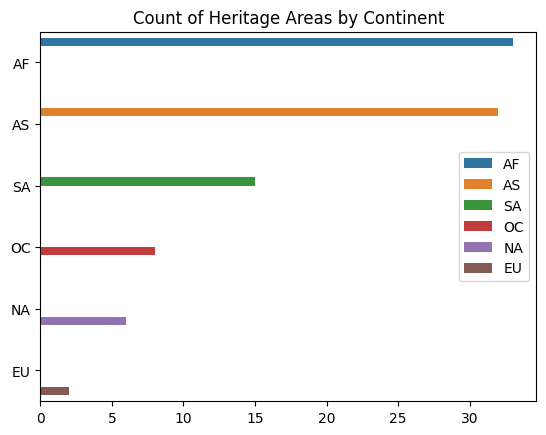

In [18]:
ax = plt.subplot()
sns.barplot(x = dataset.Continent.value_counts(ascending= False).values,
            y= dataset.Continent.unique(), ax= ax, hue= dataset.Continent.unique())
plt.title("Count of Heritage Areas by Continent")
plt.show()

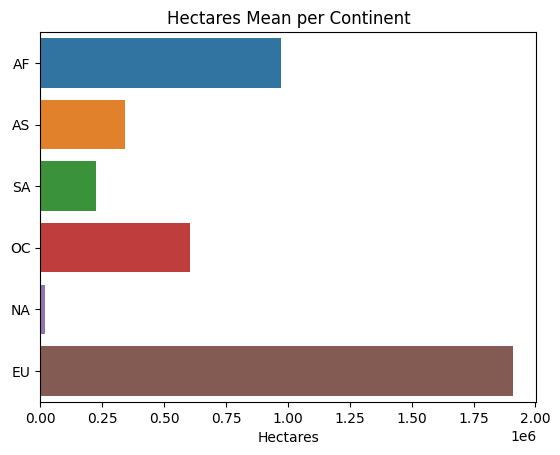

In [19]:
ax = plt.subplot()
sns.barplot(x = dataset.groupby("Continent")["Hectares"].mean(),
            y= dataset["Continent"].unique(), ax= ax)
plt.title("Hectares Mean per Continent")
plt.show()

 # Data Engineering
 Building a new variable using the Hectares mean of each Continent.

In [20]:
dataset["Hectares_Mean"] = (
    dataset.groupby("Continent")["Hectares"].transform("mean")
)

# PCA

In [21]:
columns = ['Continent', 'Criteria', 'Hectares', 'Hectares_Mean']

X = dataset[columns].values
labels = dataset.Continent
X[0]

array(['AF', 'Cultural', 182.0, 971077.2335416666], dtype=object)

### Encode Categorical Variables and Scale 

In [22]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

continent_enc = LabelEncoder()
criteria_enc = LabelEncoder()
hectares_sc = StandardScaler()

X[:, 0] = continent_enc.fit_transform(X[:, 0])
X[:, 1] = criteria_enc.fit_transform(X[:, 1])

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])], 
    remainder='passthrough')
X = ct.fit_transform(X)
X[:, [-2, -1]] = hectares_sc.fit_transform(X[:, [-2,-1]])

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 3).fit(X)
X2 = pca.transform(X)
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns = ["Variance"]).rename_axis('Components')

,Variance
Components,
0,0.491764
1,0.753186
2,0.850308


In [24]:
df_components = pd.DataFrame(X2, labels, columns= ['Component1', 'Component2', 'Component3'])\
.reset_index()
df_components

,Continent,Component1,Component2,Component3
0,AF,0.338619,-0.804815,-0.187849
1,AF,3.171847,2.791127,-0.497973
2,AS,-0.973323,0.216432,0.497208
3,AS,-0.743859,0.530108,0.509752
4,AS,-0.973413,0.216309,0.497203
...,...,...,...,...
91,AF,0.568140,-0.491061,-0.175301
92,AF,0.338575,-0.804876,-0.187851
93,AS,-0.743859,0.530108,0.509752
94,EU,-1.043836,0.248555,-0.376863


### 2 Components Plot

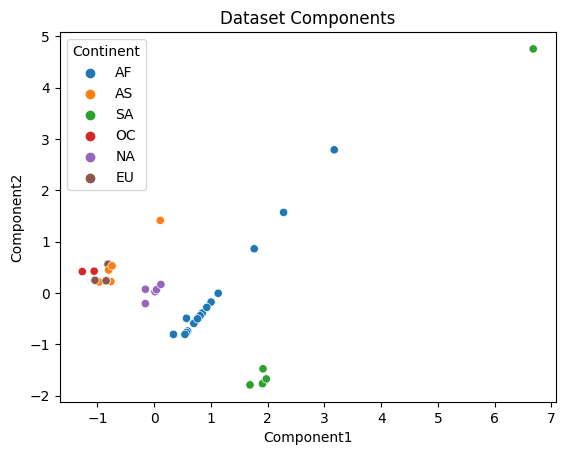

In [25]:
sns.scatterplot(data = df_components, x= "Component1", y= "Component2", hue= "Continent")
plt.title("Dataset Components")
plt.show()

### 3 Components Plot

In [26]:
fig = px.scatter_3d(data_frame= df_components, 
                    x= "Component1", y= "Component2", z= "Component3", 
                    color= "Continent", symbol= "Continent")
fig.update_layout(margin=dict(l=0, r=80, b=0, t=100))
fig.show()